# BetterFastSpeech 2: Because none of the other source codes were hackable :/
---
[Shivam Mehta](https://www.kth.se/profile/smehta)



In [3]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [20]:
import datetime as dt
from pathlib import Path

import IPython.display as ipd
import numpy as np
import soundfile as sf
import torch
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

# Hifigan imports
from fs2.hifigan.config import v1
from fs2.hifigan.denoiser import Denoiser
from fs2.hifigan.env import AttrDict
from fs2.hifigan.models import Generator as HiFiGAN
# FS2 imports
from fs2.models.fastspeech2 import FastSpeech2
from fs2.text import sequence_to_text, text_to_sequence
from fs2.utils.model import denormalize
from fs2.utils.utils import get_user_data_dir, intersperse

In [5]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
# This allows for real time code changes being reflected in the notebook, no need to restart the kernel

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Filepaths

In [26]:
FS2_CHECKPOINT = "logs/train/fs2_lj_det/runs/2024-02-26_17-27-33/checkpoints/last.ckpt"
HIFIGAN_CHECKPOINT = get_user_data_dir() / "hifigan_T2_v1"
OUTPUT_FOLDER = "synth_output"

## Load FS2

In [27]:
def load_model(checkpoint_path):
    model = FastSpeech2.load_from_checkpoint(checkpoint_path, map_location=device)
    model.eval()
    return model
count_params = lambda x: f"{sum(p.numel() for p in x.parameters()):,}"


model = load_model(FS2_CHECKPOINT)
print(f"Model loaded! Parameter count: {count_params(model)}")

Model loaded! Parameter count: 37,212,737


## Load HiFi-GAN (Vocoder)

In [28]:
def load_vocoder(checkpoint_path):
    h = AttrDict(v1)
    hifigan = HiFiGAN(h).to(device)
    hifigan.load_state_dict(torch.load(checkpoint_path, map_location=device)['generator'])
    _ = hifigan.eval()
    hifigan.remove_weight_norm()
    return hifigan

vocoder = load_vocoder(HIFIGAN_CHECKPOINT)
denoiser = Denoiser(vocoder, mode='zeros')

Removing weight norm...


### Helper functions to synthesise

In [29]:
@torch.inference_mode()
def process_text(text: str):
    x = torch.tensor(intersperse(text_to_sequence(text, ['english_cleaners2']), 0),dtype=torch.long, device=device)[None]
    x_lengths = torch.tensor([x.shape[-1]],dtype=torch.long, device=device)
    x_phones = sequence_to_text(x.squeeze(0).tolist())
    return {
        'x_orig': text,
        'x': x,
        'x_lengths': x_lengths,
        'x_phones': x_phones
    }


@torch.inference_mode()
def synthesise(text, spks=None):
    text_processed = process_text(text)
    start_t = dt.datetime.now()
    output = model.synthesise(
        text_processed['x'], 
        text_processed['x_lengths'],
        spks=spks,
        length_scale=length_scale,
        p_factor=p_factor,
        e_factor=e_factor
    )
    # merge everything to one dict    
    output.update({'start_t': start_t, **text_processed})
    return output

@torch.inference_mode()
def to_waveform(mel, vocoder):
    audio = vocoder(mel).clamp(-1, 1)
    audio = denoiser(audio.squeeze(0), strength=0.00025).cpu().squeeze()
    return audio.cpu().squeeze()
    
def save_to_folder(filename: str, output: dict, folder: str):
    folder = Path(folder)
    folder.mkdir(exist_ok=True, parents=True)
    np.save(folder / f'{filename}', output['y_pred'].cpu().numpy())
    sf.write(folder / f'{filename}.wav', output['waveform'], 22050, 'PCM_24')

## Setup text to synthesise

In [30]:
texts = [
    "The Secret Service believed that it was very doubtful that any President would ride regularly in a vehicle with a fixed top, even though transparent."
]

### Hyperparameters

In [31]:
length_scale = 1.0
p_factor=1.0
e_factor=1.0

## Synthesis

  0%|          | 0/1 [00:00<?, ?it/s]

*****************************************************
Input text - 0
-----------------------------------------------------
The Secret Service believed that it was very doubtful that any President would ride regularly in a vehicle with a fixed top, even though transparent.
*****************************************************
Phonetised text - 0
-----------------------------------------------------
_ð_ə_ _s_ˈ_i_ː_k_ɹ_ᵻ_t_ _s_ˈ_ɜ_ː_v_ɪ_s_ _b_ᵻ_l_ˈ_i_ː_v_d_ _ð_ˌ_ɐ_ɾ_ɪ_t_ _w_ʌ_z_ _v_ˈ_ɛ_ɹ_i_ _d_ˈ_a_ʊ_t_f_ə_l_ _ð_æ_t_ _ˌ_ɛ_n_i_ _p_ɹ_ˈ_ɛ_z_ɪ_d_ə_n_t_ _w_ʊ_d_ _ɹ_ˈ_a_ɪ_d_ _ɹ_ˈ_ɛ_ɡ_j_ʊ_l_ɚ_l_i_ _ɪ_n_ _ɐ_ _v_ˈ_i_ə_k_ə_l_ _w_ɪ_ð_ _ɐ_ _f_ˈ_ɪ_k_s_t_ _t_ˈ_ɑ_ː_p_,_ _ˈ_i_ː_v_ə_n_ _ð_ˌ_o_ʊ_ _t_ɹ_æ_n_s_p_ˈ_æ_ɹ_ə_n_t_._
*****************************************************
RTF:		0.004255
RTF Waveform:	0.018586


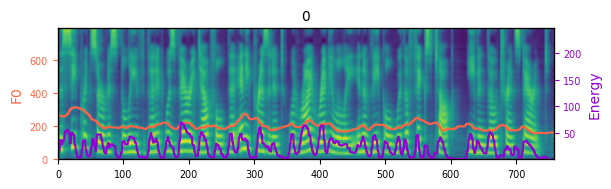

Mean RTF:				0.004255 ± 0.000000
Mean RTF Waveform (incl. vocoder):	0.018586 ± 0.000000


In [34]:
outputs, rtfs = [], []
rtfs_w = []
for i, text in enumerate(tqdm(texts)):
    output = synthesise(text) #, torch.tensor([15], device=device, dtype=torch.long).unsqueeze(0))
    output['waveform'] = to_waveform(output['y_pred'].transpose(1, 2), vocoder)

    # Compute Real Time Factor (RTF) with HiFi-GAN
    t = (dt.datetime.now() - output['start_t']).total_seconds()
    rtf_w = t * 22050 / (output['waveform'].shape[-1])

    ## Pretty print
    print(f"{'*' * 53}")
    print(f"Input text - {i}")
    print(f"{'-' * 53}")
    print(output['x_orig'])
    print(f"{'*' * 53}")
    print(f"Phonetised text - {i}")
    print(f"{'-' * 53}")
    print(output['x_phones'])
    print(f"{'*' * 53}")
    print(f"RTF:\t\t{output['rtf']:.6f}")
    print(f"RTF Waveform:\t{rtf_w:.6f}")
    rtfs.append(output['rtf'])
    rtfs_w.append(rtf_w)

    ## Display the synthesised waveform
    model.plot_mel([(output['y_pred'].squeeze().T.cpu().numpy(), output['pitch_pred'].cpu().squeeze(), output['energy_pred'].cpu().squeeze())], [f"{i}"], show=True)
    plt.show()
    ipd.display(ipd.Audio(output['waveform'], rate=22050))

    ## Save the generated waveform
    save_to_folder(i, output, OUTPUT_FOLDER)

print(f"Mean RTF:\t\t\t\t{np.mean(rtfs):.6f} ± {np.std(rtfs):.6f}")
print(f"Mean RTF Waveform (incl. vocoder):\t{np.mean(rtfs_w):.6f} ± {np.std(rtfs_w):.6f}")